<a href="https://colab.research.google.com/github/umiSirya/Weather_Prediction_capstone_project/blob/main/LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 549.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.0 MB/s eta 0:00:00


# **Import the Necessary Libraries**




In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout




# **Load the Dataset**

In [4]:
df=pd.read_csv('/content/cleaned_uv_data.csv')
df.head()

,instance_date,uv_index_daily_max
0,1999-12-31,0.304709
1,2000-01-01,0.316398
2,2000-01-02,0.329537
3,2000-01-03,0.388613
4,2000-01-04,0.384048


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4116 entries, 0 to 4115
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   instance_date       4116 non-null   object 
 1   uv_index_daily_max  4116 non-null   float64
dtypes: float64(1), object(1)
memory usage: 64.4+ KB


In [6]:
# Ensure the date column is in datetime format
df['instance_date'] = pd.to_datetime(df['instance_date'])

# Set datetime as index
df.set_index('instance_date', inplace=True)

In [7]:
df

,uv_index_daily_max
instance_date,
1999-12-31,0.304709
2000-01-01,0.316398
2000-01-02,0.329537
2000-01-03,0.388613
2000-01-04,0.384048
...,...
2017-10-27,0.944300
2017-10-28,1.545050
2017-10-29,1.468230


# **Data Pre-Processing**

In [8]:
# Define the number of test days
test_days = 60

# Split the data into training and testing sets
train_size = len(df) - test_days
train, test = df[:train_size], df[-test_days:]

# Print the sizes of each set
print(f"Training Data Size: {train.shape}")
print(f"Testing Data Size: {test.shape}")




Training Data Size: (4056, 1)
Testing Data Size: (60, 1)


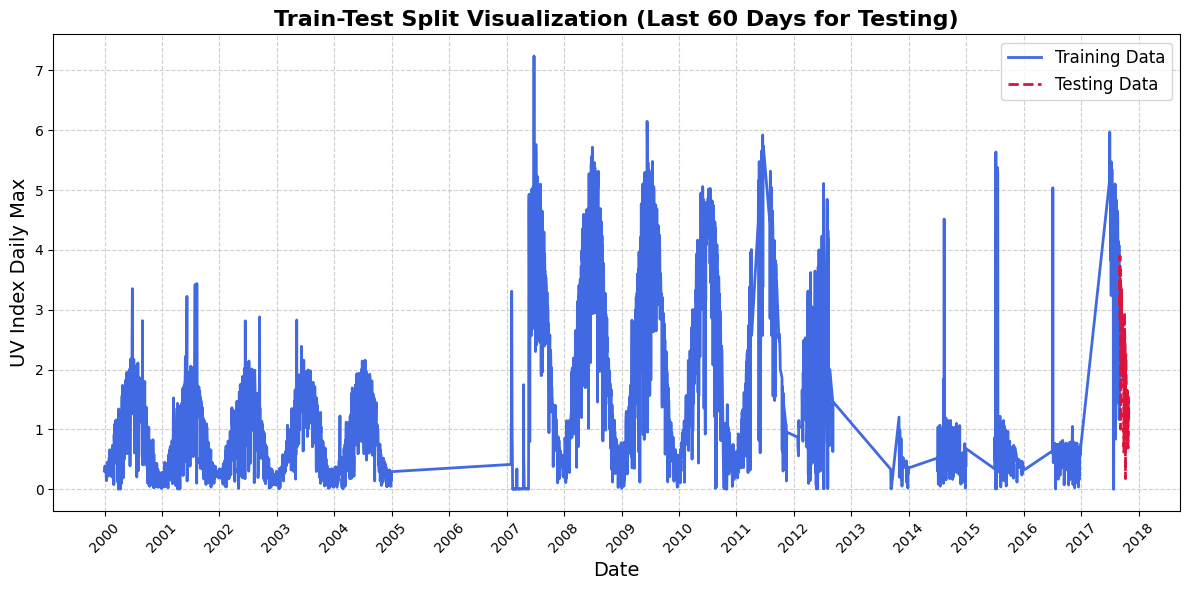

In [9]:
# Create the plot

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['uv_index_daily_max'], label="Training Data", color='royalblue', linewidth=2)
plt.plot(test.index, test['uv_index_daily_max'], label="Testing Data", color='crimson', linewidth=2, linestyle='--')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("Date", fontsize=14)
plt.ylabel("UV Index Daily Max", fontsize=14)
plt.title("Train-Test Split Visualization (Last 60 Days for Testing)", fontsize=16, fontweight='bold')
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


In [10]:
# Min-Max Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values)
test_scaled = scaler.transform(test.values)

# Sequence creation
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

# Set sequence length (e.g., 30 days)
seq_length = 30

# Create sequences for training and testing
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape data for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define LSTM Model

In [11]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50),
    Dense(1)
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Compile and Train Model

In [12]:
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0176 - val_loss: 0.0067
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0090 - val_loss: 0.0068
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0091 - val_loss: 0.0068
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0077 - val_loss: 0.0069
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0088 - val_loss: 0.0075
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0083 - val_loss: 0.0069
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0083 - val_loss: 0.0068
Epoch 9/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0080 - val_loss: 0.0075
Epoch 10/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0084 - val_loss: 0.0064
Epoch 11/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0076 - val_loss: 0.0065
Epoch 12/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 

In [13]:
# Make The Predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Inverse scale predictions back to original values
train_preds = scaler.inverse_transform(train_preds)
test_preds = scaler.inverse_transform(test_preds)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


# Model Evaluation

In [14]:
mae = mean_absolute_error(y_test_inv, test_preds)
mse = mean_squared_error(y_test_inv, test_preds)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 0.42
Mean Squared Error (MSE): 0.32
Root Mean Squared Error (RMSE): 0.57


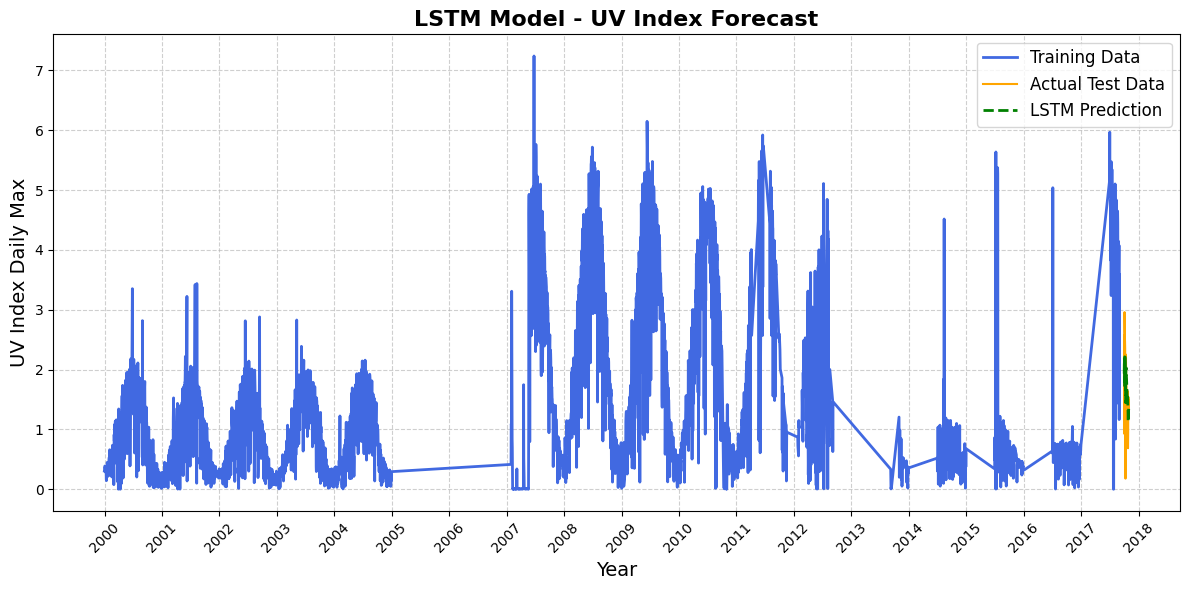

In [15]:
plt.figure(figsize=(12, 6))

plt.plot(train.index, train['uv_index_daily_max'], label="Training Data", color='royalblue', linewidth=2)
plt.plot(df.index[train_size + seq_length:], y_test_inv, color='orange', label='Actual Test Data')
plt.plot(df.index[train_size + seq_length:], test_preds, color='green', linestyle='--', linewidth=2, label='LSTM Prediction')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("Year", fontsize=14)
plt.ylabel("UV Index Daily Max", fontsize=14)
plt.title("LSTM Model - UV Index Forecast", fontsize=16, fontweight='bold')
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


Decomposition of the Predicted Values

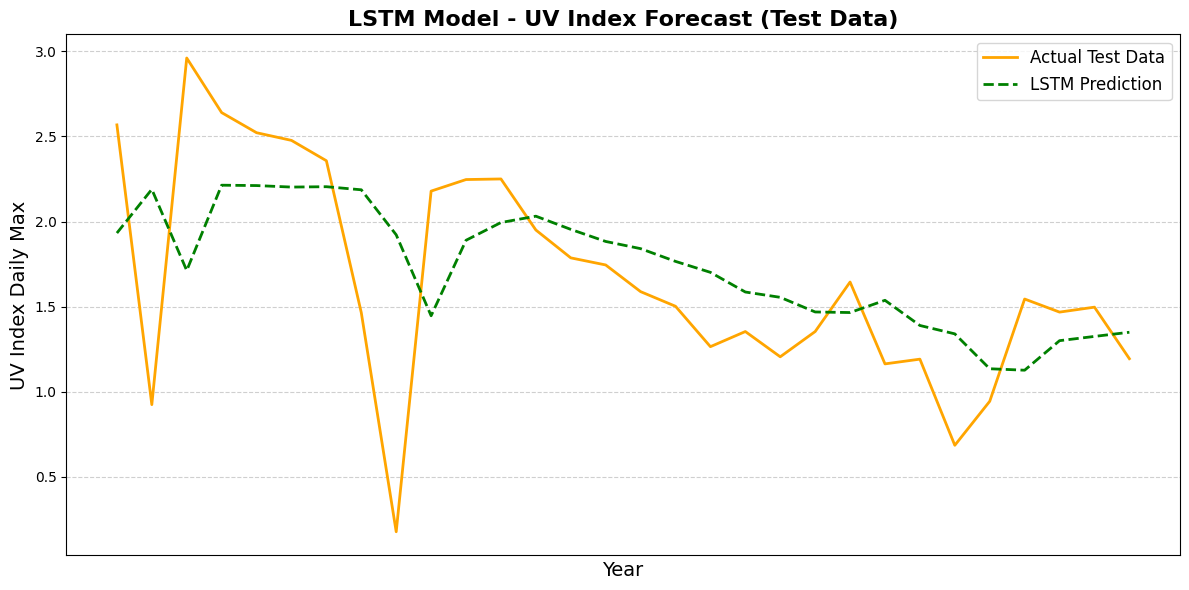

In [16]:
plt.figure(figsize=(12, 6))

# Plot only the test data and LSTM prediction
plt.plot(df.index[train_size + seq_length:], y_test_inv, color='orange', label='Actual Test Data', linewidth=2)
plt.plot(df.index[train_size + seq_length:], test_preds, color='green', linestyle='--', linewidth=2, label='LSTM Prediction')

# Format the x-axis for years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("Year", fontsize=14)
plt.ylabel("UV Index Daily Max", fontsize=14)
plt.title("LSTM Model - UV Index Forecast (Test Data)", fontsize=16, fontweight='bold')
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()
